<h1>Table of Contents<span class="tocSkip"></span></h1>
<div class="toc"><ul class="toc-item"></ul></div>

This notebook runs through the preprocessing steps for normalizing the counts matrix of the B16 screen in the Setdb1 paper.

In [18]:
import os, sys
import pandas as pd
import numpy as np

import matplotlib as mpl
mpl.rc('pdf',fonttype=42)
mpl.rcParams['pdf.use14corefonts'] = True
mpl.rcParams['axes.unicode_minus'] = False

import matplotlib.pyplot as plt

import seaborn as sns

from sklearn.linear_model import LinearRegression
from patsy import cr

from scipy.stats import norm
from scipy.stats import gaussian_kde
from statsmodels.stats.multitest import multipletests

from matplotlib import cm
from matplotlib.colors import Normalize, LinearSegmentedColormap

from scipy.stats import zscore, spearmanr, pearsonr

from tqdm import tqdm

In [19]:
from matplotlib.colors import Normalize 
from scipy.interpolate import interpn
def density_scatter(x ,y, ax=None, sort=True, bins=20, **kwargs):
    """
    Scatter plot colored by 2d histogram
    """
    if ax is None :
        fig , ax = plt.subplots()
    data , x_e, y_e = np.histogram2d( x, y, bins = bins, density = True )
    z = interpn( ( 0.5*(x_e[1:] + x_e[:-1]) , 0.5*(y_e[1:]+y_e[:-1]) ) , data , np.vstack([x,y]).T , method = "splinef2d", bounds_error = False)

    #To be sure to plot all data
    z[np.where(np.isnan(z))] = 0.0

    # Sort the points by density, so that the densest points are plotted last
    if sort :
        idx = z.argsort()
        x, y, z = x[idx], y[idx], z[idx]

    ax.scatter( x, y, c=z, **kwargs )

    return ax

In [20]:
#Load in counts data, chip file, and comparison design file
data_folder = '../data/Setdb1_paper_data/B16_screen/'
counts = pd.read_csv(data_folder + 'B16_Setdb1_counts.txt', sep='\t', index_col=0)
chip = pd.read_csv(data_folder + 'CP1367_GRCm38_NCBI_strict_gene_20191022.chip', delimiter='\t', index_col=0)
design = pd.read_csv(data_folder + 'B16_Setdb1_replicate_map.txt', delimiter='\t', index_col=0)

ctrl_sg = [_ for _ in counts.index if '_' in chip.loc[_, 'Gene Symbol']]
comp_design = design[['Sample', 'Control']].dropna().drop_duplicates()
comp_design = comp_design.reset_index().drop('Replicate', axis=1)

In [21]:
# normalize and compute LFCs
libsize = counts.sum(axis=0)
rpm = counts / libsize * 1E6 + 1
lrpm = np.log2(rpm)
lrpm.to_csv(data_folder + 'log2rpm.txt', sep='\t')

# aggregate by condition
log2var = lrpm.groupby(by=design['Sample'], axis=1).var()[design['Sample'].unique()]
log2rpm = lrpm.groupby(by=design['Sample'], axis=1).mean()[design['Sample'].unique()]
log2rpm.to_csv(data_folder + 'log2rpm_averaged.txt', sep='\t')

# control distribution
log2rpm_mean_ctrl = log2rpm.loc[ctrl_sg].mean()
log2rpm_std_ctrl = log2rpm.loc[ctrl_sg].std()

# zscore normalize
zlog2rpm = (log2rpm - log2rpm_mean_ctrl) / log2rpm_std_ctrl
zlog2var = log2var / log2rpm_std_ctrl ** 2


100%|██████████| 4/4 [00:00<00:00, 24.66it/s]


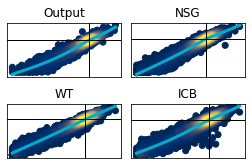

In [22]:
# calculate zlfc and residuals from natural cubic spline of znorm abundances
resid = pd.DataFrame(index=counts.index)
zlfc = pd.DataFrame(index=counts.index)

ncols=2
nrows=4//ncols + 4%ncols

plt.figure(None, (ncols*1.8, nrows*1.2))
for i, (s, c) in tqdm(enumerate(zip(comp_design['Sample'], comp_design['Control'])), total=len(comp_design)):
    ax = plt.subplot(nrows, ncols, i+1)
    x = zlog2rpm[c]
    y = zlog2rpm[s]
    clr='#00adcc'  # for cividis
    
    # calculate spline
    x_basis = cr(x, df=4, constraints='center')
    model = LinearRegression().fit(x_basis, y)
    y_hat = model.predict(x_basis)
    
    # plot points with density
    cm = plt.cm.cividis
    density_scatter(x, y, ax=ax, cmap=cm)
    ax.set_title(s.replace('_', ' ').replace('IO', 'ICB'))
    idx = np.argsort(x)
    
    ax.plot(x[idx], y_hat[idx], color=clr, linewidth=3)
    ax.axvline(0, linestyle='-', linewidth=1, color='k')
    ax.axhline(0, linestyle='-', linewidth=1, color='k')
    ax.tick_params(
        axis='both',
        which='both',
        left=False,
        bottom=False,
        labelleft=False,
        labelbottom=False)

    resid[s] = y - y_hat
    zlfc[s] = y - x
plt.tight_layout()
plt.show()

In [23]:
zlfc_g = zlfc.loc[chip.index].groupby(chip['Gene Symbol']).mean()
zlfc_g.to_csv(data_folder + 'genes_zlfc.txt', sep='\t')
resid_g = resid.loc[chip.index].groupby(chip['Gene Symbol']).mean()
resid_g.to_csv(data_folder + 'genes_zresid.txt', sep='\t')
zlfc.to_csv(data_folder + 'guides_zlfc.txt', sep='\t')
resid.to_csv(data_folder + 'guides_zresid.txt', sep='\t')